In [ ]:
# 1.8 Installing OpenCV on your own machine
!pip3 install numpy
!pip3 install opencv-python
!pip3 install opencv-contrib-python

import cv2
print(cv2.__version__)

# cv2.__file__
rootPath = '/usr/local/lib/python3.7/dist-packages/cv2/'

4.1.2


In [ ]:
# 3.3 Coding up algorithms
def mean(im):
  "Calculate the mean of the image im."
  print(im.shape)
  ny, nx, nc = im.shape
  total = 0
  for y in range (0, ny):
    for x in range (0, nx):
      for c in range (0, nc):
        total += im[y,x,c]
  return total / ny / nx / nc

"""path = 'fpr01.png'
im = cv2.imread(path, 1) # 0->grey, 1->rgb
mean(im)"""

# 3.4 Histograms and their manipulation
import sys, cv2, numpy, pylab
def iround (x):
  "Convert x to the nearest whole number."
  return int (round (x))

#round(3.3)

def hist (im):
  "Return the grey-level histogram of an image, ready for plotting."
  # The maximum image value that we support.
  maxgrey = 256
  # Create the values for the abscissa (x-axis).
  ab = numpy.ndarray (maxgrey)
  for i in range (0, maxgrey):
    ab[i] = i
  # Create the histogram array and set it from the image.
  h = numpy.zeros (maxgrey)
  for y in range (0, ny):
    for x in range (0, nx):
      for c in range (0, nc):
        v = im[y,x,c]
        h[v] += 1
  # Return the x and y values.
  return ab, h

def plot_hist (x, y, fn):
  "Plot the histogram of image fn."
  # Set up pylab.
  pylab.figure ()
  pylab.xlim (0, 255)
  pylab.grid ()
  pylab.title ("Histogram of " + fn)
  pylab.xlabel ("grey level")
  pylab.ylabel ("number of occurrences")
  pylab.bar (x, y, align="center")
  pylab.show ()
  return

#-------------------------------------------------------------------------------
# Main program.
#-------------------------------------------------------------------------------
# Set-up.
maxdisp = 800

# Ensure the command line is sensible.
"""
if len (sys.argv) < 2:
  print ("Usage:", sys.argv[0], "<image>...", file=sys.stderr)
  sys.exit (1)
"""

fn = 'fpr01.png'
# Process the files given on the command line.
  #for fn in sys.argv[1:]:
# Read in the image and print out its dimensions.
im = cv2.imread (fn)
ny, nx, nc = im.shape
print (fn + ":")
print (" Dimensions:", nx, "pixels,", ny, "lines,", nc, "channels.")
# Calculate and output some important statistics.
print (" Range: %d to %d" % (im.min (), im.max ()))
print (" Mean: %.2f (using mean)" % mean (im))
print (" Mean: %.2f (using numpy method)" % im.mean ())
print (" Standard deviation: %.2f" % im.std ())
# Work out and display the histogram.
x, h = hist (im)
plot_hist (x, h, fn)
# For display, ensure the image is no more than maxdisp pixels in x or y.
if ny > maxdisp or nx > maxdisp:
  nmax = max (ny, nx)
  fac = maxdisp / nmax
  nny = iround (ny * fac)
  nnx = iround (nx * fac)
  print (" [re-sizing to %d x %d pixels for display]" % (nnx, nny))
  im = cv2.resize (im, (nnx, nny))


# Display the image.
"""
cv2.imshow (fn, im)
cv2.waitKey (0)
cv2.destroyWindow (fn)
"""

# cv2.imshow cannot run on colab
from google.colab.patches import cv2_imshow
cv2_imshow(im)
print ()
#-------------------------------------------------------------------------------
# End of summarize.
#-------------------------------------------------------------------------------

# 3.5 Contrast-stretching and an improved histogram routine
def histogram (im, bins=64, limits=None):
  """Work out the histogram of the image 'im'. The histogram is
  accumulated in 'bins' bins. By default, these lie between the
  minimum and maximum values of 'im' but other extrema can be
  provided in 'limits', a list comprising the low and high limits
  to be used. Values outside these extrema are ignored."""

  # Find the extreme values in the image.
  if limits is None: limits = [im.min(), im.max()]
  lo, hi = limits

  # Create the arrays to hold the values to be plotted.
  h = numpy.zeros (bins)
  a = numpy.zeros (bins)

  # Fill the x array with the centres of the bins.
  inc = (hi - lo) / (bins - 1)
  for i in range (0, bins):
    a[i] = lo + i * inc

  # Accumulate the histogram.
  ny, nx, nc = im.shape
  for y in range (0, ny):
    for x in range (0, nx):
      for c in range (0, nc):
        v = int ((im[y,x,c] - lo) / (hi - lo) * (bins-1) + 0.5)
        if v >= 0 and v < bins:
          h[v] += 1.0
  # Return the abscissa and ordinate arrays.
  return a, h

x, h = histogram (im)
plot_hist (x, h, fn)

# 3.6 Histogram equalisation
def cumulative_histogram (im, bins=256, limits=None):
  "Find the cumulative histogram of an image"
  a, h = histogram (im, bins=bins, limits=limits)
  for i in range (1, len(h)):
    h[i] = h[i] + h[i-1]
  return a, h

# same as: h.cumsum()
a, h = cumulative_histogram(im)

# not used/tested
def lut (im, table, limits=None):
  "Look up each pixel of an image in a table"
  if limits is None: limits = extrema (im)
  lo, hi = limits
  ny, nx, nc = sizes (im)
  bins = len (table)
  for y in range (0, ny):
    for x in range (0, nx):
      for c in range (0, nc):
        v = (im[y,x,c] - lo) / (hi - lo) * (bins-1)
        im[y,x,c] = table[int(v)]


# 3.7 Content-based image retrieval using histograms
import math
def sd_slow (im):
  "Return the standard deviation of an image (two-pass)"
  ny, nx, nc = im.shape
  total = 0
  for y in range (0, ny):
    for x in range (0, nx):
      for c in range (0, nc):
        total += im[y,x,c]
  n = ny * nx * nc
  mean = total / n

  total = 0.0
  for y in range (0, ny):
    for x in range (0, nx):
      for c in range (0, nc):
        v = im[y,x,c] - mean
        total += v * v
  v = total / n
  return math.sqrt (v)

# there is some problem for this function
# because the v is negative value
import numpy as np
def sd (im):
  "Return the standard deviation of an image"
  ny, nx, nc = im.shape
  total = 0.0
  total2 = 0.0
  for y in range (0, ny):
    for x in range (0, nx):
      for c in range (0, nc):
        v = im[y,x,c]
        total += v
        total2 = total2 + v * v # overflow if float64
  n = ny * nx * nc
  v = (total2 - total**2/n) / n 
  return math.sqrt (v/n)

# ,sd (im)
print( sd_slow(im) )

# wrong, overflow
def correlation_coefficient (im1, im2):
  "Calculate the correlation coefficient between two images"
  ny, nx, nc = im1.shape
  sumx = sumy = sumxx = sumyy = sumxy = 0.0
  for y in range (0, ny):
    for x in range (0, nx):
      for c in range (0, nc):
        v1 = im1[y,x,c]/255 # if not divivde by 255, it will overflow
        v2 = im2[y,x,c]/255 # if not divivde by 255, it will overflow
        sumx += v1
        sumy += v2
        sumxx += v1 * v1
        sumxy += v1 * v2
        sumyy += v2 * v2
  n = ny * nx * nc
  v1 = sumxy - sumx * sumy / n
  v2 = math.sqrt((sumxx-sumx*sumx/n) * (sumyy-sumy*sumy/n))
  #v2 = im1.std() * im2.std()
  return v1 / v2

# 


im1 = cv2.imread (fn)
im2 = cv2.imread (fn)
correlation_coefficient (im1, im2)

#!/usr/bin/env python3
"Demonstrate content-based image retrieval using histograms"
import sys, math, cv2
#------------------------------------------------------------------------------
#<<Calculate the correlation coefficient>>
#<<Calculate the histogram>>
#------------------------------------------------------------------------------
# Say hello and initialize things.

"""
if len(sys.argv) < 3:
  print ("Usage:", sys.argv[0], "<probe> <test-images>", file=sys.stderr)
  sys.exit (1)
"""
probe_file = sys.argv[1]
v_best = 0
f_best = "?"

# Read in the probe image and find its histogram.
probe_file = fn
im1 = cv2.imread (probe_file)
a, probe = histogram (im1, limits=[0,255])

# We now enter the main loop. The basic idea is to load an image,
# find its histogram, then compare that with the histogram of the
# probe image. We are careful to skip the case when the test
# image is the same as the probe.

"""
for file in sys.argv[2:]:
  if file != probe_file:
"""
file = fn
print ("Processing", file)
im2 = cv2.imread (file)
a, h = histogram (im2, limits=[0,255])
#v = correlation_coefficient (probe, h)
v = correlation_coefficient (im1, im2)
if v > v_best:
  v_best = v
  f_best = file

# We've finished our work so say which of the test set best matches the
# probe and exit.
print ("Best match is", f_best, "with correlation", v_best)

AttributeError: ignored

In [ ]:
# 4.6 Implementing convolution
# this function cannot run
def convolve (im, mask, statistic='sum'):
  """
  Perform a convolution of im with mask, returning the result.

  Arguments:
  im the image to be convolved with mask (modified)
  mask the convolution mask to be used
  statistic one of:
  sum conventional convolution
  mean conventional convolution
  median median filtering
  min grey-scale shrink (reduces light areas)
  max grey-scale expand (enlarges light areas)
  """
  im = reshape3 (im) # this line is not runnable
  ny, nx, nc = sizes (im)
  mask = reshape3 (mask) # this line is not runnable
  my, mx, mc = sizes (mask)
  yo = my // 2
  xo = mx // 2

  # Create an output image of the same size as the input.
  result = image (im)

  # We need a special case for 'min' statistic to erase the mask elements
  # that are zero.
  nzeros = len ([x for x in mask.ravel() if x == 0])

  # Loop over the pixels in the image. For each pixel position, multiply
  # the region around it with the mask, summing the elements and storing
  # that in the equivalent pixel of the output image.
  v = numpy.zeros ((my*mx*mc))
  vi = 0
  for yi in range (0, ny):
    for xi in range (0, nx):
      for ym in range (0, my):
        yy = (ym + yi - yo) % ny
        for xm in range (0, mx):
          xx = (xm + xi - xo) % nx
          v[vi] = im[yy,xx,0] * mask[ym,xm,0]
          vi += 1

      if statistic == 'sum':
        ave = numpy.sum (v)
      elif statistic == 'mean':
        ave = numpy.mean (v)
      elif statistic == 'max':
        ave = numpy.max (v)
      elif statistic == 'min':
        v = sorted (v)
        ave = numpy.min (v[nzeros:])
      elif statistic == 'median':
        ave = numpy.median (v)
      result[yi,xi,0] = ave
      vi = 0
  return result

# Skeletonize a binary image
"""
skel = im
while True:
  eroded = shrink (im, mask)
  opened = expand (eroded, mask)
  temp = im - opened
  skel = bitwise_or (skel, temp)
  if eroded.sum () == 0:
    break
  im = copy (eroded)
"""
lap_mask = [ [-1,-1,-1], [-1,8,-1],[-1,-1,-1] ]
"""tmp_im = convolve(im, lap_mask, 'mean')
cv2_imshow(tmp_im)"""

In [ ]:
#!unzip left.zip
#!unzip right.zip

left_path = 'left/left-020.png'
right_path = 'right/right-000.png'
left = cv2.imread (left_path)
right = cv2.imread (right_path)

# y, x, c
# ((480, 640, 3), (480, 640, 3))
left.shape, right.shape

# get all positions of any pixel where RGB > 0 
# because the background is black whose RGB = 0
import numpy as np

def getInfo(im):
  ny, nx, nc = im.shape
  #print(ny, nx, nc)
  pos = []
  for i in range(ny):
    for j in range(nx):
      r = im[i, j, 0]
      g = im[i, j, 1]
      b = im[i, j, 2]
      s = int(r) + int(g) + int(b)
      if s<1:
        pass
      elif s<100 or s>750:
        #print([i, j, r, g, b, s])
        pass
      else:
        tmp = [i, j]
        pos.append(tmp)         
  pos = np.array(sorted(pos, key=lambda x: x[0]))
  #print(pos.shape)
  return pos

from sklearn.cluster import KMeans
# use k-means to get clusters 
def getClusters(im, nc=7):
  X = getInfo(im)
  kmeans = KMeans(n_clusters=nc, random_state=0).fit(X)
  #print(kmeans.labels_)
  #print( kmeans.labels_.shape )
  cluster = avgColor(im, X, kmeans.labels_)
  """pos = kmeans.cluster_centers_
  pos = np.rint(pos) #np.round(pos, 0)
  yaxis, xaxis = pos.shape
  #yaxis, xaxis
  cluster = []
  for i in range(yaxis):
    y = int(pos[i][0])
    x = int(pos[i][1])
    b = im[y, x, 0]
    g = im[y, x, 1]
    r = im[y, x, 2]
    cluster.append( [y, x, r, g, b] )"""
  return cluster

def avgColor(im, X, labels):
  dic = {}
  for i in range( len(labels) ):
    v = labels[i]
    if v not in dic:
      dic[v] = [i]
    else:
      dic[v].append(i)
  #print(dic)
  update = []
  for i in dic:
    cds = dic[i]
    cl = len(cds)
    py = 0
    px = 0
    bt, gt, rt = 0.0, 0.0, 0.0
    for c in cds:
      y = X[c, 0]
      x = X[c, 1]
      b = im[y, x, 0]
      g = im[y, x, 1]
      r = im[y, x, 2]
      py = py + y
      px = px + x
      bt = bt + b
      gt = gt + g
      rt = rt + r
    update.append( [py/cl, px/cl, rt/cl, gt/cl, bt/cl] )
  update = np.array(update)
  #print( np.rint( update ) )
  return np.rint( update )

# by averaging with 8-connect region
def getRGB(im, y, x):
  count = 0
  bt, gt, rt = 0.0, 0.0, 0.0
  for i in range(y-3, y+4):
    for j in range(x-3, x+4):
      b = im[y, x, 0]
      g = im[y, x, 1]
      r = im[y, x, 2]
      bt = bt + b
      gt = gt + g
      rt = rt + r
      count = count + 1
  print('============', bt, gt, rt)
  return np.round(bt/count), np.round(gt/count), np.round(rt/count)

import math
# match the left and right clusters
def matchClusters(left_cluster, right_cluster):
  ny, nx = left_cluster.shape
  #print( ny, nx )
  match = {}
  for i in range(ny):
    #
    yl = left_cluster[i, 0]
    """xl = left_cluster[i, 1]
    rl = left_cluster[i, 2]
    gl = left_cluster[i, 3]
    bl = left_cluster[i, 4]"""
    for j in range(ny):
      #
      yr = right_cluster[j, 0]
      """xr = right_cluster[j, 1]
      rr = right_cluster[j, 2]
      gr = right_cluster[j, 3]
      br = right_cluster[j, 4]"""

      # filter, match
      if abs(yl-yr)<=3:
        if i in match:
          pre = match[i]
          #print('-------', )
          find = choose(left_cluster, right_cluster, i, pre, j, match)
          match[i] = find
        else:
          match[i] = j
  tmp = []
  for k in match:
    i = k
    j = match[k]
    left = left_cluster[i]
    right = right_cluster[j]
    #mth = np.concatenate((left, right), axis=0)
    mth = [left, right]
    #print(mth)
    tmp.append(mth)
  return np.array(tmp)

def choose(left_cluster, right_cluster, i, pre, j, match):
  flag = False
  d = -1
  for k in match:
    li = k
    ri = match[k]
    if ri == j:
      flag = True
      d = clusterDistance( left_cluster[li], right_cluster[ri] )

  L = left_cluster[i]
  R1 = right_cluster[pre]
  R2 = right_cluster[j]
  
  d1 = clusterDistance(L, R1)
  d2 = clusterDistance(L, R2)

  if d1<=d2:
    return pre
  if flag and d<=d2:
    return pre
  return j

def clusterDistance(L, R):
  rl = L[2]
  gl = L[3]
  bl = L[4]
  #
  rr = R[2]
  gr = R[3]
  br = R[4]

  rd = abs(rl - rr) + 1
  gd = abs(gl - gr) + 1
  bd = abs(bl - br) + 1
  return int(rd)*int(gd)*int(bd)

# left & right path
# read them as image
def readFrame(i):
  left_path = 'left/left-0'
  right_path = 'right/right-0'
  if i<10:
    left_path = left_path + '0' + str(i) + '.png'
    right_path = right_path + '0' + str(i) + '.png'
  else:
    left_path = left_path + str(i) + '.png'
    right_path = right_path + str(i) + '.png'
  print( left_path, right_path )
  return cv2.imread(left_path), cv2.imread(right_path)

def calDis(obj):
  # focal lengths of 12 m
  # baseline 3.5 km
  f = 12.0
  B = 3.5*1000
  half_img_x = 640/2
  micron = math.pow(10, -6)
  xL = obj[0, 1] - half_img_x
  xR = obj[1, 1] - half_img_x
  #print(xL, xR)
  Z = f*B/( (xL - xR)*micron*10 )
  #print(Z)
  return Z

"""
red:	r
yellow:	r+g (almost same r and g)
blue:	b
white:	r+g+b
cyan:	g+b
green:	g
glod:	r+g	(more r and less g)
"""
def identify(obj):
  # obj is the left & right (y, x, r, g, b)
  lo = obj[0]
  #ro = obj[1]
  r = lo[2]
  g = lo[3]
  b = lo[4]
  if r>100 and almostZero(g) and almostZero(b):
    return 'red'
  if almostSame(r, g) and almostZero(b):
    return 'yellow'
  if b>100 and almostZero(r) and almostZero(g):
    return 'blue'
  if almostSame(r, g) and almostSame(r, b):
    return 'white'
  if almostSame(g, b) and almostZero(r):
    return 'cyan'
  if g>100 and almostZero(r) and almostZero(b):
    return 'green'
  return 'glod'

import pandas as pd
cols = ['red', 'yellow', 'blue', 'white', 'cyan', 'green', 'glod']
df = pd.DataFrame(columns = cols)
df1 = pd.DataFrame(columns = cols)

# every left & right frame, cluster them, get a match
def identifyAll(match, frame, df, df1):
  dic = {}
  dic['frame'] = frame
  dic1 = {}
  dic1['frame'] = frame
  ny, nc, nx = match.shape
  for i in range(ny):
    obj = match[i]
    label = identify(obj)
    dis = calDis(obj)
    #print(obj, label, dis)
    dic[label] = dis
    pi = posInfo(obj)
    dic1[label] = pi
  #print(dic)
  df = df.append(dic, ignore_index=True)
  df1 = df1.append(dic1, ignore_index=True)
  return df, df1

def posInfo(obj):
  #st = "(" + str(obj[0]) + "), "
  #st = st + "(" + str(obj[1]) + ")"
  st = str(obj[0][1]) + ',' + str(obj[0][0])
  st = st + '-' + str(obj[1][1]) + ',' + str(obj[1][0])
  return st

def almostZero(v):
  if v<50:
    return True
  return False

def almostSame(v1, v2):
  if abs(v1-v2)<10:
    return True
  return False

for i in range(5, 46):
  left, right = readFrame(i)
  left_cluster = getClusters(left)
  right_cluster = getClusters(right)
  match = matchClusters(left_cluster, right_cluster)
  #print( match )
  df, df1 = identifyAll(match, i, df, df1)


"""
r=g=b>0
r>0, g=b=0, r-200
r>0, g=b=0, r-150
g>0, r=b=0
b>0, r=g=0
r=g>0, b=0
r>0, g>0, b=0
"""

print()
df

left/left-005.png right/right-005.png
left/left-006.png right/right-006.png
left/left-007.png right/right-007.png
left/left-008.png right/right-008.png
left/left-009.png right/right-009.png
left/left-010.png right/right-010.png
left/left-011.png right/right-011.png
left/left-012.png right/right-012.png
left/left-013.png right/right-013.png
left/left-014.png right/right-014.png
left/left-015.png right/right-015.png
left/left-016.png right/right-016.png
left/left-017.png right/right-017.png
left/left-018.png right/right-018.png
left/left-019.png right/right-019.png
left/left-020.png right/right-020.png
left/left-021.png right/right-021.png
left/left-022.png right/right-022.png
left/left-023.png right/right-023.png
left/left-024.png right/right-024.png
left/left-025.png right/right-025.png
left/left-026.png right/right-026.png
left/left-027.png right/right-027.png
left/left-028.png right/right-028.png
left/left-029.png right/right-029.png
left/left-030.png right/right-030.png
left/left-03

,red,yellow,blue,white,cyan,green,glod,frame
0,1.166667e+08,1.235294e+08,1.200000e+08,1.166667e+08,1.135135e+08,1.166667e+08,1.105263e+08,5.0
1,1.166667e+08,1.200000e+08,1.166667e+08,1.166667e+08,1.105263e+08,1.105263e+08,1.135135e+08,6.0
2,1.105263e+08,1.166667e+08,1.166667e+08,1.105263e+08,1.076923e+08,1.105263e+08,1.076923e+08,7.0
3,1.105263e+08,1.135135e+08,1.166667e+08,1.105263e+08,1.105263e+08,1.050000e+08,1.050000e+08,8.0
4,1.076923e+08,1.105263e+08,1.135135e+08,1.076923e+08,1.050000e+08,1.050000e+08,1.050000e+08,9.0
5,1.050000e+08,1.105263e+08,1.105263e+08,1.076923e+08,1.000000e+08,1.000000e+08,1.050000e+08,10.0
6,1.024390e+08,1.105263e+08,1.076923e+08,1.050000e+08,1.000000e+08,1.000000e+08,1.000000e+08,11.0
7,1.000000e+08,1.050000e+08,1.050000e+08,1.024390e+08,1.000000e+08,9.767442e+07,9.767442e+07,12.0
8,9.545455e+07,1.000000e+08,1.050000e+08,1.000000e+08,9.545455e+07,9.545455e+07,9.545455e+07,13.0
9,9.545455e+07,1.000000e+08,1.000000e+08,6.176471e+07,9.130435e+07,9.545455e+07,9.130435e+07,14.0


In [ ]:
df1

,red,yellow,blue,white,cyan,green,glod,frame
0,"322.0,208.0-286.0,208.0","312.0,219.0-278.0,218.0","332.0,219.0-297.0,219.0","332.0,228.0-296.0,228.0","321.0,236.0-284.0,236.0","322.0,238.0-286.0,238.0","360.0,238.0-322.0,238.0",5.0
1,"322.0,206.0-286.0,206.0","312.0,218.0-277.0,218.0","333.0,218.0-297.0,218.0","333.0,228.0-297.0,228.0","321.0,235.0-283.0,235.0","323.0,238.0-285.0,238.0","360.0,238.0-323.0,238.0",6.0
2,"324.0,206.0-286.0,206.0","312.0,218.0-276.0,218.0","334.0,218.0-298.0,218.0","334.0,228.0-296.0,228.0","321.0,234.0-282.0,234.0","323.0,238.0-285.0,238.0","362.0,238.0-323.0,238.0",7.0
3,"324.0,205.0-286.0,204.0","313.0,217.0-276.0,216.0","334.0,217.0-298.0,216.0","335.0,227.0-297.0,227.0","320.0,234.0-282.0,234.0","324.0,238.0-284.0,238.0","364.0,238.0-324.0,238.0",8.0
4,"324.0,204.0-285.0,204.0","314.0,216.0-276.0,216.0","335.0,216.0-298.0,216.0","336.0,226.0-297.0,227.0","320.0,232.0-280.0,232.0","324.0,238.0-284.0,238.0","364.0,238.0-324.0,238.0",9.0
5,"325.0,203.0-285.0,203.0","314.0,216.0-276.0,216.0","336.0,216.0-298.0,216.0","336.0,226.0-297.0,226.0","320.0,232.0-278.0,232.0","326.0,238.0-284.0,238.0","366.0,238.0-326.0,238.0",10.0
6,"326.0,202.0-285.0,202.0","314.0,214.0-276.0,214.0","337.0,215.0-298.0,214.0","338.0,226.0-298.0,226.0","320.0,230.0-278.0,230.0","326.0,237.0-284.0,237.0","368.0,237.0-326.0,237.0",11.0
7,"326.0,200.0-284.0,200.0","315.0,214.0-275.0,214.0","338.0,214.0-298.0,214.0","338.0,225.0-297.0,225.0","318.0,230.0-276.0,229.0","327.0,237.0-284.0,237.0","370.0,236.0-327.0,237.0",12.0
8,"328.0,200.0-284.0,200.0","316.0,214.0-274.0,214.0","338.0,214.0-298.0,213.0","340.0,224.0-298.0,224.0","318.0,228.0-274.0,228.0","328.0,236.0-284.0,236.0","372.0,236.0-328.0,236.0",13.0
9,"328.0,198.0-284.0,198.0","316.0,212.0-274.0,212.0","340.0,212.0-298.0,212.0","340.0,224.0-272.0,227.0","318.0,227.0-272.0,227.0","328.0,236.0-284.0,236.0","374.0,236.0-328.0,236.0",14.0


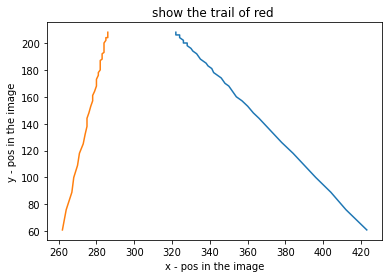

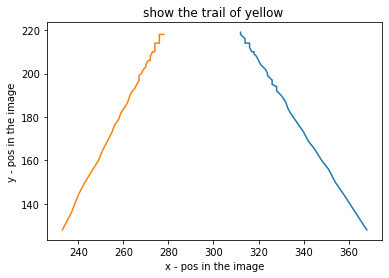

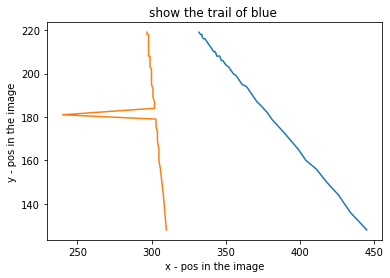

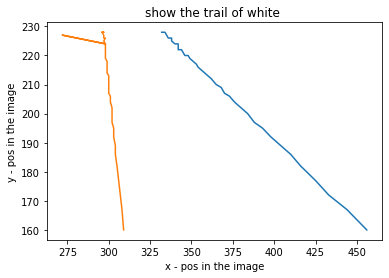

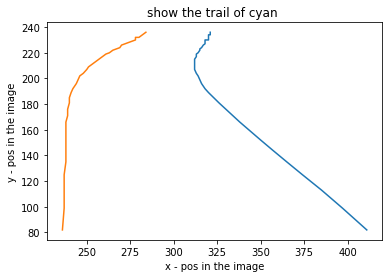

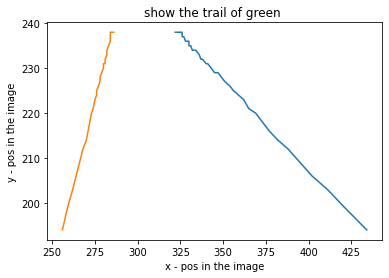

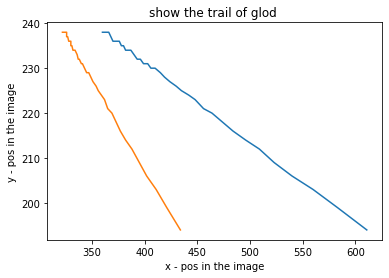

"leftx, lefty, rightx, righty = getXY(df1, 'blue')\na, b = formStraightLine(leftx, lefty)\naccumulate(a, b, leftx, lefty)"

In [ ]:
def getXY(df1, col='red'):
  sub = df1[col]
  leftx = []
  lefty = []
  rightx = []
  righty = []
  for i in range(len(sub)):
    st = sub[i]
    #print(st)
    lns = st.split('-')
    lt = lns[0]
    rt = lns[1]
    #
    xy = lt.split(',')
    leftx.append( float(xy[0]) )
    lefty.append( float(xy[1]) )
    #
    xy = rt.split(',')
    rightx.append( float(xy[0]) )
    righty.append( float(xy[1]) )
  return leftx, lefty, rightx, righty


import matplotlib.pyplot as plt 

def drawTrail(x1, y1, x2, y2, lal='red'):
  plt.plot(x1, y1, label = "left")
  plt.plot(x2, y2, label = "right")
  plt.xlabel('x - pos in the image') 
  plt.ylabel('y - pos in the image') 
  plt.title('show the trail of ' + lal + ' ') 
  plt.show() 
  return 
# 
objects = ['red', 'yellow', 'blue', 'white', 'cyan', 'green', 'glod']
for lal in objects:
  leftx, lefty, rightx, righty = getXY(df1, lal)
  drawTrail(leftx, lefty, rightx, righty, lal)


def formStraightLine(leftx, lefty):
  nx = np.array(leftx)
  ny = np.array(lefty)
  #
  mx = nx.mean()
  my = ny.mean()
  #
  size = len(leftx)
  size = size//3
  mx1 = nx[:size].mean()
  my1 = ny[:size].mean()
  #
  # y = ax + b
  # (mx, my), (mx1, my1)
  a = (my1 - my) / (mx1 - mx)
  b = my - a*mx
  print(mx, my, mx1, my1, a, b)
  return a, b

def accumulate(a, b, leftx, lefty):
  size = len(leftx)
  print('there are ' + str(size) + ' points')
  count = 0
  for i in range(size):
    x = leftx[i]
    y = lefty[i]
    y_pred = a * x + b
    error = abs(y_pred - y)
    print(error)
    if error < 2:
      count = count + 1
  return count

# 'red', 'yellow', 'blue', 'white', 'cyan', 'green', 'glod'
"""leftx, lefty, rightx, righty = getXY(df1, 'blue')
a, b = formStraightLine(leftx, lefty)
accumulate(a, b, leftx, lefty)"""

In [ ]:
# 5.2 Isolating regions by thresholding
# Otsu’s method for choosing a thresholdi
def otsu (im):
  "Determine the threshold by Otsu's method."
  # Initialization.
  nr, nc, nb = im.shape
  npixels = nr * nc * nb
  # Work out the histogram.
  ngreys = int (im.max () + 1.5) # round the value
  hist = numpy.zeros (ngreys)
  for r in range (0, nr):
    for c in range (0, nc):
      for b in range (0, nb):
        v = int (im[r,c,b] + 0.5) # round the value
        hist[v] += 1

  # Step over all the possible thresholds, calculating the between-class
  # variance at each step and working out its maximum as we go.
  sum = eve.sum (im)  # eve cannot run here
  sumB = totB = threshold = max_var = 0
  for t in range (0, ngreys):
    sumB += hist[t]
    if sumB == 0: continue
    sumF = npixels - sumB
    if sumF == 0: break
    totB += t * hist[t]
    mB = totB / sumB
    mF = (sum - sumB) / sumF
    var = (sumB / sum) * (sumF / sum) * (mB - mF)**2
    if var > max_var:
      max_var = var
      threshold = t
  return threshold

# 5.3 Region labelling
# Threshold and label images
#import sys, eve

# The first argument should be the threshold, and all others filenames.
"""
if len (sys.argv) < 3:
  print >>sys.stderr, "Usage:", sys.argv[0], "<threshold> <file>..."
  sys.exit (1)
threshold = float (sys.argv[1])
"""
threshold = 100
# Loop over the images, processing each in turn.
# for fn in sys.argv[2:]:
fn = 'fpr01.png'
"""
im = eve.image (fn)
mim = eve.mono (im)
mask = eve.binarize (mim, threshold)
mask, nregs = eve.label_regions (mask)
print (nregs, "regions found.")
eve.display (mask, stretch=True)
"""



In [ ]:
# 7.3 The Hough transform for straight lines
# Hough transform
def find_peaks (im, threshold=10):
  ny, nx, nc = im.shape
  peaks = list ()
  for y in range (1, ny-1):
    for x in range (1, nx-1):
      if im[y,x,0] > im[y-1,x-1,0] \
        and im[y,x,0] > im[y-1,x ,0] \
        and im[y,x,0] > im[y-1,x+1,0] \
        and im[y,x,0] > im[y ,x-1,0] \
        and im[y,x,0] > im[y ,x+1,0] \
        and im[y,x,0] > im[y+1,x-1,0] \
        and im[y,x,0] > im[y+1,x ,0] \
        and im[y,x,0] > im[y+1,x+1,0] \
        and im[y,x,0] > threshold:
        peaks.append ([im[y,x,0], y, x])
  # Return the peaks sorted into descending order.
  peaks.sort (reverse=True)
  return peaks

def hough_line (im, nr=300, na=200, threshold=10, max_peaks=None):
  im = reshape3 (im)
  ny, nx, nc = sizes (im)
  acc = image ((nr, na, 1))
  ainc = math.pi / na
  rinc = math.sqrt (ny**2 + nx**2) / nr

  # Fill arrays with the radius and angle values, to be returned.
  rvals = []
  for i in range (0, nr):
    rvals += [i * rinc]

  avals = []
  for i in range (0, na):
    avals += [i * ainc]

  # Find non-zero points and update the Hough accumulator.
  for y in range (0, ny):
    for x in range (0, nx):
      val = im[y,x,0]
      if val > 0:
        for ia in range (0, na):
          ang = ia * ainc
          r = x * math.cos(ang) + y * math.sin (ang)
          ir = int (r / rinc)
          acc[ir,ia,0] += 1

  # Find peaks in the accumulator.
  peaks = find_peaks (acc, threshold=threshold)
  if max_peaks is None:
    max_peaks = len (peaks)

  return peaks, acc, rvals, avals




In [ ]:
# 8.3 Viola-Jones: Haar Features and Adaptive Boosting
# Integral image calculation

def calc_sat_slow (im):
  "Form an integral image from an image by the obvious approach."
  ny, nx, nc = im.shape
  sat = numpy.zeros ((ny,nx,1))

  # The first row and column are special cases.
  sat[0,0] = im[0,0]
  for x in range (1, nx):
    sat[0,x] = sat[0,x-1] + im[0,x]
  for y in range (1, ny):
    sat[y,0] = sat[y-1,0] + im[y,0]
  
  # For the remainder of the image, we add up all the pixels
  # within a region.
  for ylim in range (1, ny):
    for xlim in range (1, nx):
      regsum = 0.0
      for y in range (0, ylim+1):
        for x in range (0, xlim+1):
          regsum += im[y,x]
      sat[ylim,xlim] = regsum
  return sat

def calc_sat (im):
  "Form an integral image from an image."
  ny, nx, nc = im.shape
  sat = numpy.zeros ((ny,nx,1))

  # The first row and column are special cases.
  sat[0,0] = im[0,0]
  for x in range (1,nx):
    sat[0,x] = im[0,x] + sat[0,x-1]
  for y in range (1, ny):
    sat[y,0] = im[y,0] + sat[y-1,0]

  # For the remainder of the image, we use the algebraic identity to
  # compute integral image values at pixels.
  for y in range (1, ny):
    for x in range (1, nx):
      sat[y,x] = im[y,x] + sat[y,x-1] + sat[y-1,x] - sat[y-1,x-1]
  return sat

# Integral image calculation
def get_sat (sat, ylo, yhi, xlo, xhi):
  """Return the area of a rectangular region of an image from its
  integral image."""
  # We have to do a little fiddling around with indices because the way
  # Python indices work does not quite match how an integral image is
  # most naturally indexed...so it is not quite constant in time.
  # Sigh.
  ylo -= 1
  xlo -= 1
  if ylo < 0:
    if xlo < 0:
      res = sat[yhi,xhi]
    else:
      res = sat[yhi,xhi] - sat[yhi,xlo]
  elif xlo < 0:
    res = sat[yhi,xhi] - sat[ylo,xhi]
  else:
    res = sat[yhi,xhi,0] + sat[ylo,xlo,0] - sat[yhi,xlo,0] - sat[ylo,xhi,0]
  return res

"""
#The following short program shows how the routines are used:
# Create and fill an image.
im = eve.image ((10,10,1))
eve.set (im, 1)
# Work out the correct sum of a rectangular region of it.
correct = im[4:6,1:3].sum()
# Form the integral image.
sat = calc_sat (im)
# Print out the correct sum and the value obtained from
# the integral image.
print correct, get_sat (sat, 4, 5, 1, 2)
"""

# Using Viola-Jones in OpenCV

# Viola-Jones face detection
def detect (im):
  "Detect a face using Haar cascades, as in Viola-Jones."
  rp = '/usr/local/lib/python3.7/dist-packages/cv2/'
  # https://github.com/avelino/python-opencv-detect
  tmp = 'haarcascade_frontalface_alt.xml'
  tmp = 'haarcascade_eye.xml'
  cascade = cv2.CascadeClassifier (tmp) #
  #
  #print( "cascade" , cascade )
  gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  faces = cascade.detectMultiScale (gray, scaleFactor=1.1, minNeighbors=5)

  # Locate the faces and draw the surrounding rectangles on the images.
  # If we are to locate eyes too, do the same with them.
  for (x, y, w, h) in faces:
    print (" ", x ,y, x+w, y+h)
    reg = im[y:y+h,x:x+w]
    cv2.rectangle (im, (x,y), (x+w,y+h), (255,0,0), 2)

  # Return the faces found and the marked-up image.
  return im, faces

# test
fn = 'girl01.png'
im = cv2.imread (fn)
cv2_imshow(im)

im_new, face_new = detect (im)
cv2_imshow(im_new)
cv2_imshow(face_new)


In [ ]:
# 9.7 Correcting perspective effects
# Finding the perspective transform
def find_perspective_transform (src, dst):
  """This routine calculates the coefficients of the
  perspective transformation which maps (xi,yi) to
  (ui,vi), (i=1,2,3,4)."""
  n = len (pos)
  if n != 4: raise Exception ("Wrong number of matches.")
  a = numpy.zeros ((8,8), dtype=numpy.float32)
  b = numpy.zeros ((8), dtype=numpy.float32)
  m = numpy.zeros ((3,3), dtype=numpy.float32)
  for i in range (0, 4):
    a[i,0] = a[i+4,3] = src[i,0]
    a[i,1] = a[i+4,4] = src[i,1]
    a[i,2] = a[i+4,5] = 1
    a[i,3] = a[i,4] = a[i,5] = a[i+4,0] = a[i+4,1] = a[i+4,2] = 0
    a[i,6] = -src[i,0] * dst[i,0]
    a[i,7] = -src[i,1] * dst[i,0]
    a[i+4,6] = -src[i,0] * dst[i,1]
    a[i+4,7] = -src[i,1] * dst[i,1]
    b[i] = dst[i,0]
    b[i+4] = dst[i,1]
  # Solve the set of equations and copy the solution into a transformation
  # matrix, which we return.
  x = numpy.linalg.solve (a, b)
  m[0,0] = x[0]
  m[1,0] = x[3]
  m[2,0] = x[6]
  m[0,1] = x[1]
  m[1,1] = x[4]
  m[2,1] = x[7]
  m[0,2] = x[2]
  m[1,2] = x[5]
  m[2,2] = 1.0
  return m

# Finding the perspective transform
#!/usr/bin/env python
'''Image rectification using OpenCV.'''
from __future__ import division
import sys, numpy, cv2

# Define the image containing the region to extract and the boundaries
# of the region.
pos = numpy.zeros ((4,2), dtype=numpy.float32)
fn = "psychology.jpg"
pos[0,:] = [249, 337] # ULx, ULy
pos[1,:] = [238, 483] # LLx, LLy
pos[2,:] = [548, 501] # LRx, LRy
pos[3,:] = [557, 190] # URx, URy
# Define the size of the output image and the region of it we want to fill.
n = m = 512
opos = numpy.zeros ((4,2), dtype=numpy.float32)
opos[0,:] = [0, 0]
opos[1,:] = [0, n-1]
opos[2,:] = [m-1, n-1]
opos[3,:] = [m-1, 0]
# Work out the transformation from the match-points.
xform = find_perspective_transform (pos, opos)
# Invoke OpenCV routines to extract the region.
im = cv2.imread (fn)
warp = cv2.warpPerspective (im, xform, (m, n))
cv2.imwrite ("rectified.jpg", warp)
#cv2.waitKey ()

cv2_imshow(cv2.imread( 'rectified.jpg' ))

In [ ]:
# 10.5 Support vector machines



In [ ]:
# 11.4 Convolutional neural networks

numpy.ndarray

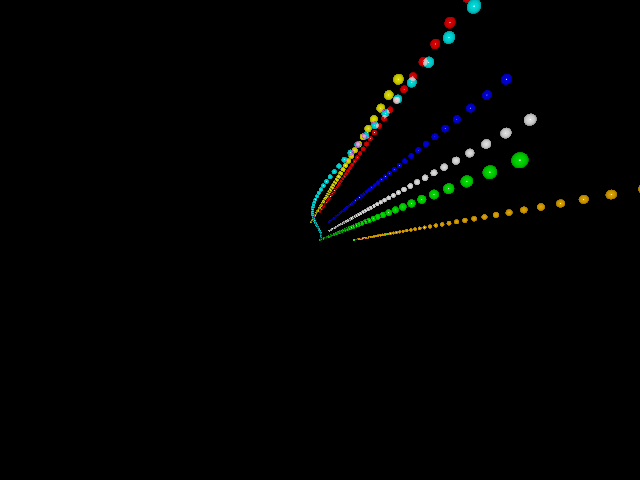

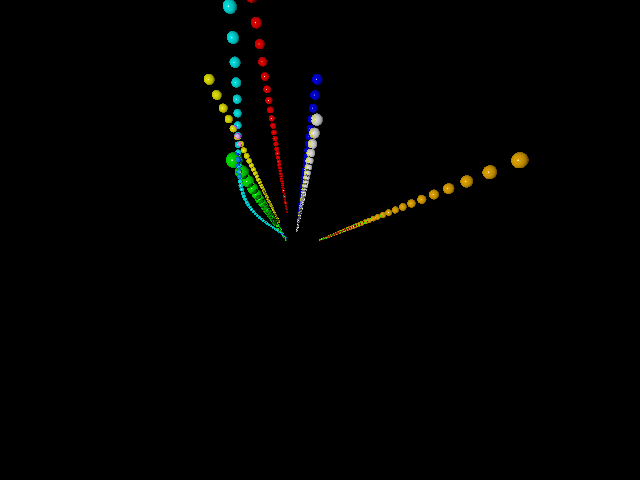

In [ ]:
import numpy as np

def addImg(im1, im2):
  return np.add(im1, im2)


"""
tmp_path = 'left/left/left-000.png'
tmp_im = cv2.imread (tmp_path)
tmp_im.shape

for i in range(1,10):
  tmp_path = 'left/left/left-00'+ str(i) +'.png'
  tmp_im = addImg( tmp_im, cv2.imread (tmp_path) )
  print(tmp_path)
cv2_imshow(tmp_im)
"""

prefix = 'left/left/left'
def synthesizeImg(prefix, suffix, start, end):
  # read the first image
  path = prefix + "-0"
  if start < 10:
    path = path + '0' + str(start)
  else:
    path = path + str(start)
  path = path + suffix
  #print(path)
  im = cv2.imread(path)
  
  # add with the following images
  i = start + 1
  while i<= end:
    path = prefix + "-0"
    if i < 10:
      path = path + '0' + str(i)
    else:
      path = path + str(i)
    path = path + suffix
    #print(path)
    im1 = cv2.imread(path)
    im = addImg(im, im1)
    i = i + 1

  return im


#tmp = addImg(left, right)

tmp = synthesizeImg('left/left', '.png', 0, 49)
cv2_imshow( tmp )
print()
tmp = synthesizeImg('right/right', '.png', 0, 49)
cv2_imshow( tmp )

In [ ]:
# 
def identify(im):
  categories = im[:,:,1].flatten().tolist()
  return list(set(categories))

tmp_path = 'left/left-000.png'
for i in range(0,10):
  tmp_path = 'left/left-00'+ str(i) +'.png'
  tmp_set = identify( cv2.imread(tmp_path) )
  print( sorted(tmp_set) )
for i in range(10,50):
  tmp_path = 'left/left-0'+ str(i) +'.png'
  tmp_set = identify( cv2.imread(tmp_path) )
  print( sorted(tmp_set) )

In [ ]:
# task:
# 1. identify each visible object in each frame
# 2. calculate their distance from the cameras
#     from the positions of objects in the left and right images
# 3. record the 3D position of each object 
# 4. try to establish which are, and which are not, travelling in straight lines
# 5. checked using a test harness
# 6. run by command line
